In [1]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [2]:
ls

MyDrive/  Shareddrives/


In [3]:
cd/gdrive/MyDrive/Soil type classification/

/gdrive/MyDrive/Soil type classification


In [4]:
ls

'Black Soil'/  'Laterite Soil'/  'Yellow Soil'/


In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [6]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')

In [8]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=30
CHANNELS=3

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/Soil type classification",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 96 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
class_names

['Black Soil', 'Laterite Soil', 'Yellow Soil']

In [11]:
len(dataset)

2

In [12]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[50.210938 41.210938 36.210938]
  [57.6875   48.6875   43.6875  ]
  [69.53906  60.539062 55.539062]
  ...
  [56.078125 51.078125 47.078125]
  [48.476562 39.003906 36.79297 ]
  [47.       37.       35.      ]]

 [[52.79669  43.79669  38.79669 ]
  [51.113586 42.113586 37.113586]
  [59.49414  50.49414  45.49414 ]
  ...
  [53.860474 48.860474 44.860474]
  [47.01544  37.542786 35.33185 ]
  [45.84375  35.84375  33.84375 ]]

 [[57.83441  48.83441  43.83441 ]
  [46.191162 37.191162 32.191162]
  [52.124634 43.124634 38.124634]
  ...
  [48.868713 43.868713 39.868713]
  [46.57312  37.100464 34.889526]
  [45.901062 35.901062 33.901062]]

 ...

 [[61.3468   53.3468   50.3468  ]
  [41.425415 33.425415 30.425415]
  [34.887634 26.887634 23.887634]
  ...
  [48.526733 43.526733 39.526733]
  [47.622192 43.25116  40.14569 ]
  [49.380066 45.08319  42.08319 ]]

 [[61.65851  53.65851  50.65851 ]
  [39.318054 31.318054 28.318054]
  [40.184326 32.184326 29.184326]
  ...
  [46.674

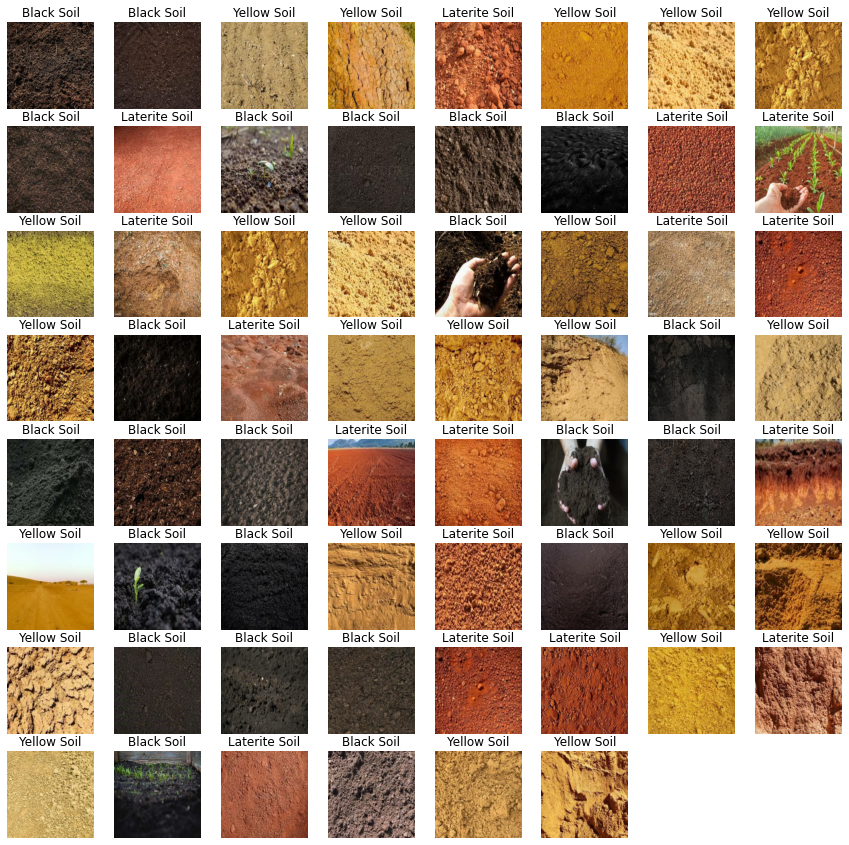

In [13]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
1/1 [==============================] - 6s 6s/step - loss: 2.1918 - accuracy: 0.2353
Epoch 2/30
1/1 [==============================] - 4s 4s/step - loss: 2.0889 - accuracy: 0.2353
Epoch 3/30
1/1 [==============================] - 4s 4s/step - loss: 1.8794 - accuracy: 0.2353
Epoch 4/30
1/1 [==============================] - 4s 4s/step - loss: 1.6176 - accuracy: 0.2353
Epoch 5/30
1/1 [==============================] - 4s 4s/step - loss: 1.5225 - accuracy: 0.2353
Epoch 6/30
1/1 [==============================] - 4s 4s/step - loss: 1.3450 - accuracy: 0.2353
Epoch 7/30
1/1 [==============================] - 4s 4s/step - loss: 1.2644 - accuracy: 0.3235
Epoch 8/30
1/1 [==============================] - 4s 4s/step - loss: 1.1761 - accuracy: 0.3235
Epoch 9/30
1/1 [==============================] - 4s 4s/step - loss: 1.1931 - accuracy: 0.4412
Epoch 10/30
1/1 [==============================] - 4s 4s/step - loss: 1.1928 - accuracy: 0.4412
Epoch 11/30
1/1 [==============================] 

In [22]:
model.evaluate(test_ds)

1/1 [==============================] - 1s 1s/step - loss: 0.6872 - accuracy: 0.9118


[0.6872286200523376, 0.9117646813392639]

In [23]:
acc = history.history['accuracy']
loss = history.history['loss']

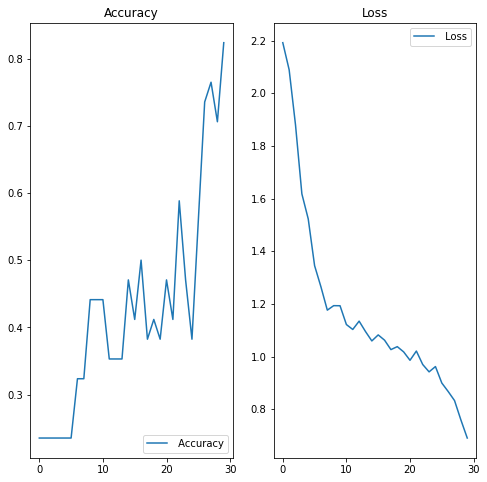

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

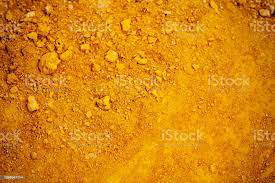

In [25]:
image_path = "/gdrive/My Drive/download (3).jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [26]:
pred = model.predict(scaled_img)

In [27]:
output = class_names[np.argmax(pred)]

In [28]:
output

'Laterite Soil'

In [29]:
model.save("Soil type classification.h5")